In [1]:
import zipfile, os, cv2
import numpy as np
import tensorflow as tf
import pandas as pd
tf.executing_eagerly()
from tensorflow import keras
from tensorflow.keras import layers
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nibabel as nib
from skimage import morphology
from scipy import ndimage
from PIL import Image
MRI_nii_folder_path = 'nii_save_np/lacune/'

In [2]:
seed = 3
# seed: cv1=1 cv2=2 cv3=3 cv4=4 cv5=5

In [3]:
cv = seed
train_val_x = np.load(MRI_nii_folder_path+f'cv{cv}_x_ctrain_val.npy')
train_val_y = np.load(MRI_nii_folder_path+f'cv{cv}_y_ctrain_val.npy')
train_val_path = np.load(MRI_nii_folder_path+f'cv{cv}_path_train_val.npy')
print(train_val_x.shape,train_val_y.shape,train_val_path.shape)

(129, 32, 192, 192) (129,) (129,)


In [4]:
print(int(train_val_x.shape[0]*0.8))

103


In [5]:
x_train = train_val_x[:103]
y_train = train_val_y[:103]
x_val = train_val_x[103:]
y_val = train_val_y[103:]
train_path = train_val_path[:103]
valid_path = train_val_path[103:]

In [6]:
from keras.utils.np_utils import to_categorical
imgs_train = x_train.astype(np.float32)
imgs_valid = x_val.astype(np.float32)
# imgs_label_train = to_categorical(y_train, 2)
# imgs_label_valid = to_categorical(y_val, 2)
imgs_label_train = y_train.astype(int)
imgs_label_valid = y_val.astype(int)
print(imgs_train.shape)
print(imgs_label_train.shape)
print(imgs_valid.shape)
print(imgs_label_valid)
print(train_path.shape)
print(valid_path.shape)

(103, 32, 192, 192)
(103,)
(26, 32, 192, 192)
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(103,)
(26,)


In [7]:
# class weights
from sklearn.utils.class_weight import compute_class_weight
classes=[0,1]
cw = compute_class_weight('balanced', classes, y_train)
print(f"moderate-severe = 0:{cw[0]}, mild = 1:{cw[1]}")
# print(cw)
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 0] = cw[0].astype(np.float32)
sample_weight[y_train == 1] = cw[1].astype(np.float32)
# print(y_train)
# print(sample_weight)

moderate-severe = 0:0.8583333333333333, mild = 1:1.197674418604651
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439 1.19767439
 1.19767439 0.85833335 0.85833335 0.85833335 0.85833335 0.85833335
 0.85833335 0.85833335 0.85833335 0.85833335 0.85833335 0.85833335
 0.85833335 0.8

/home/john/anaconda3/envs/er_tf2/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pixel max = 1 pixel min = 0
pixel max = 6.0720720291137695 pixel min = 0.0


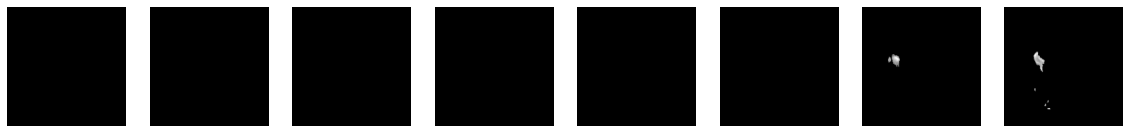

In [8]:
plt.figure(figsize=(20,20))
mask_arr_ = imgs_train[50]
print(f"pixel max = {np.max(imgs_label_valid)} pixel min = {np.min(imgs_label_valid)}")
print(f"pixel max = {np.max(imgs_train)} pixel min = {np.min(imgs_train)}")
for i in range(mask_arr_.shape[0]-24):
    plt.subplot(1,mask_arr_.shape[0]-24,i+1)
    plt.axis('off')
    plt.imshow(mask_arr_[i],cmap='gray')

In [9]:
from utils.processing_data import train_preprocessing, validation_preprocessing

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((imgs_train, imgs_label_train, sample_weight))
validation_loader = tf.data.Dataset.from_tensor_slices((imgs_valid, imgs_label_valid))

batch_size = 4

In [11]:
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
#     .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
#     .prefetch(2)
)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from utils.model_1 import get_model
model = get_model(depth=32, width=192, height=192, class_num=1, classification_layer='sigmoid')
# model.summary()

(None, 30, 95, 95, 64)
(None, 14, 46, 93, 64)
(None, 6, 22, 91, 128)
(None, 2, 10, 89, 256)


In [13]:
from keras import backend as K
def binary_focal_loss(gamma=2, alpha=0.25):

    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return binary_focal_loss_fixed
focal_loss = binary_focal_loss(gamma=2, alpha=0.25)

In [14]:
import datetime, keras.callbacks
initial_learning_rate = 1e-5
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    # loss="binary_crossentropy",
    loss=focal_loss,
    optimizer=keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc')
             ,tf.keras.metrics.AUC(name = 'auc')
             ,tf.keras.metrics.Recall(name = 'rec')
            ],
)

# Define callbacks.
save_path ='chekpoint/lacune/'
checkpoint_name = f"154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv{cv}_t1_cw"
tlogdir = os.path.join("chekpoint/logs_lacune/", checkpoint_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tlogdir,histogram_freq=1)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{save_path}{checkpoint_name}.h5", monitor="val_acc", verbose=1, save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=30)
reduceLR_cb = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=15, 
                                                factor=0.1, verbose=1, min_lr=1e-8)

In [15]:
weight_path=save_path+checkpoint_name+'.h5'
print(weight_path)

chekpoint/lacune/154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv3_t1_cw.h5


In [16]:
# Train the model, doing validation at the end of each epoch
epochs = 150
history = model.fit(train_dataset,validation_data=validation_dataset,
                    epochs=epochs,shuffle=True,verbose=1,
                    callbacks=[checkpoint_cb,
                              #  early_stopping_cb,
                               tensorboard_callback,
                              ]
                    )

Epoch 1/150
26/26 [==============================] - ETA: 0s - loss: 0.0783 - acc: 0.7379 - auc: 0.8213 - rec: 0.8605
Epoch 00001: val_acc improved from -inf to 0.42308, saving model to chekpoint/lacune/154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv3_t1_cw.h5
26/26 [==============================] - 23s 870ms/step - loss: 0.0783 - acc: 0.7379 - auc: 0.8213 - rec: 0.8605 - val_loss: 0.0984 - val_acc: 0.4231 - val_auc: 0.6212 - val_rec: 1.0000
Epoch 2/150
26/26 [==============================] - ETA: 0s - loss: 0.0710 - acc: 0.7573 - auc: 0.8277 - rec: 0.8605
Epoch 00002: val_acc did not improve from 0.42308
26/26 [==============================] - 20s 788ms/step - loss: 0.0710 - acc: 0.7573 - auc: 0.8277 - rec: 0.8605 - val_loss: 0.1020 - val_acc: 0.4231 - val_auc: 0.5000 - val_rec: 1.0000
Epoch 3/150
26/26 [==============================] - ETA: 0s - loss: 0.0713 - acc: 0.6602 - auc: 0.7488 - rec: 0.6512
Epoch 00003: val_acc did not improve from 0.42308
26/26 [========================

Epoch 23/150
26/26 [==============================] - ETA: 0s - loss: 0.0548 - acc: 0.7087 - auc: 0.8269 - rec: 0.4651
Epoch 00023: val_acc improved from 0.69231 to 0.76923, saving model to chekpoint/lacune/154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv3_t1_cw.h5
26/26 [==============================] - 21s 790ms/step - loss: 0.0548 - acc: 0.7087 - auc: 0.8269 - rec: 0.4651 - val_loss: 0.0784 - val_acc: 0.7692 - val_auc: 0.8091 - val_rec: 0.8182
Epoch 24/150
26/26 [==============================] - ETA: 0s - loss: 0.0470 - acc: 0.7379 - auc: 0.8828 - rec: 0.5581
Epoch 00024: val_acc did not improve from 0.76923
26/26 [==============================] - 22s 827ms/step - loss: 0.0470 - acc: 0.7379 - auc: 0.8828 - rec: 0.5581 - val_loss: 0.0789 - val_acc: 0.7692 - val_auc: 0.8727 - val_rec: 0.8182
Epoch 25/150
26/26 [==============================] - ETA: 0s - loss: 0.0483 - acc: 0.8155 - auc: 0.8940 - rec: 0.6744
Epoch 00025: val_acc did not improve from 0.76923
26/26 [==================

Epoch 46/150
26/26 [==============================] - ETA: 0s - loss: 0.0412 - acc: 0.7670 - auc: 0.9031 - rec: 0.6047
Epoch 00046: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 778ms/step - loss: 0.0412 - acc: 0.7670 - auc: 0.9031 - rec: 0.6047 - val_loss: 0.1055 - val_acc: 0.6923 - val_auc: 0.8939 - val_rec: 0.2727
Epoch 47/150
26/26 [==============================] - ETA: 0s - loss: 0.0452 - acc: 0.7476 - auc: 0.8700 - rec: 0.6047
Epoch 00047: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 785ms/step - loss: 0.0452 - acc: 0.7476 - auc: 0.8700 - rec: 0.6047 - val_loss: 0.1070 - val_acc: 0.6538 - val_auc: 0.8909 - val_rec: 0.1818
Epoch 48/150
26/26 [==============================] - ETA: 0s - loss: 0.0418 - acc: 0.7767 - auc: 0.9070 - rec: 0.5814
Epoch 00048: val_acc did not improve from 0.84615
26/26 [==============================] - 21s 790ms/step - loss: 0.0418 - acc: 0.7767 - auc: 0.9070 - rec: 0.5814 - val_lo

Epoch 69/150
26/26 [==============================] - ETA: 0s - loss: 0.0394 - acc: 0.7670 - auc: 0.9151 - rec: 0.6279
Epoch 00069: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 783ms/step - loss: 0.0394 - acc: 0.7670 - auc: 0.9151 - rec: 0.6279 - val_loss: 0.1040 - val_acc: 0.7308 - val_auc: 0.8848 - val_rec: 0.3636
Epoch 70/150
26/26 [==============================] - ETA: 0s - loss: 0.0378 - acc: 0.8350 - auc: 0.9273 - rec: 0.6744
Epoch 00070: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 783ms/step - loss: 0.0378 - acc: 0.8350 - auc: 0.9273 - rec: 0.6744 - val_loss: 0.1081 - val_acc: 0.6923 - val_auc: 0.8818 - val_rec: 0.2727
Epoch 71/150
26/26 [==============================] - ETA: 0s - loss: 0.0354 - acc: 0.8544 - auc: 0.9384 - rec: 0.7442
Epoch 00071: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 772ms/step - loss: 0.0354 - acc: 0.8544 - auc: 0.9384 - rec: 0.7442 - val_lo

Epoch 92/150
26/26 [==============================] - ETA: 0s - loss: 0.0376 - acc: 0.8155 - auc: 0.9306 - rec: 0.6279
Epoch 00092: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 784ms/step - loss: 0.0376 - acc: 0.8155 - auc: 0.9306 - rec: 0.6279 - val_loss: 0.1066 - val_acc: 0.8462 - val_auc: 0.8788 - val_rec: 0.6364
Epoch 93/150
26/26 [==============================] - ETA: 0s - loss: 0.0462 - acc: 0.8058 - auc: 0.8930 - rec: 0.6744
Epoch 00093: val_acc did not improve from 0.84615
26/26 [==============================] - 21s 820ms/step - loss: 0.0462 - acc: 0.8058 - auc: 0.8930 - rec: 0.6744 - val_loss: 0.1078 - val_acc: 0.8462 - val_auc: 0.8788 - val_rec: 0.6364
Epoch 94/150
26/26 [==============================] - ETA: 0s - loss: 0.0386 - acc: 0.8641 - auc: 0.9374 - rec: 0.7442
Epoch 00094: val_acc did not improve from 0.84615
26/26 [==============================] - 20s 787ms/step - loss: 0.0386 - acc: 0.8641 - auc: 0.9374 - rec: 0.7442 - val_lo

Epoch 115/150
26/26 [==============================] - ETA: 0s - loss: 0.0326 - acc: 0.8252 - auc: 0.9560 - rec: 0.6512
Epoch 00115: val_acc did not improve from 0.88462
26/26 [==============================] - 21s 796ms/step - loss: 0.0326 - acc: 0.8252 - auc: 0.9560 - rec: 0.6512 - val_loss: 0.1026 - val_acc: 0.8077 - val_auc: 0.8697 - val_rec: 0.5455
Epoch 116/150
26/26 [==============================] - ETA: 0s - loss: 0.0355 - acc: 0.8835 - auc: 0.9432 - rec: 0.7674
Epoch 00116: val_acc did not improve from 0.88462
26/26 [==============================] - 21s 804ms/step - loss: 0.0355 - acc: 0.8835 - auc: 0.9432 - rec: 0.7674 - val_loss: 0.1046 - val_acc: 0.8462 - val_auc: 0.8758 - val_rec: 0.7273
Epoch 117/150
26/26 [==============================] - ETA: 0s - loss: 0.0410 - acc: 0.7282 - auc: 0.8986 - rec: 0.5116
Epoch 00117: val_acc did not improve from 0.88462
26/26 [==============================] - 21s 790ms/step - loss: 0.0410 - acc: 0.7282 - auc: 0.8986 - rec: 0.5116 - val

Epoch 138/150
26/26 [==============================] - ETA: 0s - loss: 0.0315 - acc: 0.8350 - auc: 0.9624 - rec: 0.6744
Epoch 00138: val_acc did not improve from 0.88462
26/26 [==============================] - 20s 787ms/step - loss: 0.0315 - acc: 0.8350 - auc: 0.9624 - rec: 0.6744 - val_loss: 0.1295 - val_acc: 0.6154 - val_auc: 0.8576 - val_rec: 0.0909
Epoch 139/150
26/26 [==============================] - ETA: 0s - loss: 0.0345 - acc: 0.8835 - auc: 0.9446 - rec: 0.8372
Epoch 00139: val_acc did not improve from 0.88462
26/26 [==============================] - 21s 797ms/step - loss: 0.0345 - acc: 0.8835 - auc: 0.9446 - rec: 0.8372 - val_loss: 0.1260 - val_acc: 0.8462 - val_auc: 0.8788 - val_rec: 0.7273
Epoch 140/150
26/26 [==============================] - ETA: 0s - loss: 0.0387 - acc: 0.8447 - auc: 0.9252 - rec: 0.6977
Epoch 00140: val_acc did not improve from 0.88462
26/26 [==============================] - 21s 805ms/step - loss: 0.0387 - acc: 0.8447 - auc: 0.9252 - rec: 0.6977 - val

In [17]:
weight_path=save_path+checkpoint_name+'.h5'
print(weight_path)

chekpoint/lacune/154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv3_t1_cw.h5


In [18]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test = x_val
imgs_mask_test = imgs_label_valid


print('-'*30)
print('Loading saved weights...')
print('-'*30)

model = get_model(depth=32, width=192, height=192, class_num=1)


model.load_weights(weight_path)

------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
(None, 30, 95, 95, 64)
(None, 14, 46, 93, 64)
(None, 6, 22, 91, 128)
(None, 2, 10, 89, 256)


In [19]:
Results = model.predict(imgs_test, batch_size=1, verbose=1)

26/26 [==============================] - 1s 32ms/step


In [20]:
argmax_pred = np.reshape((Results>0.5).astype(int),(len(Results)))
argmax_truth = imgs_label_valid.astype(int)

In [21]:
Pred_dict ={}
Trut_dict ={}
nii_data=[]
count = 0
for i in valid_path:
    nii_data.append(i[-14:-8])

result_df = {'nii name':nii_data,
             'Prediction': argmax_pred,
             'GroundTruth':argmax_truth
            }
results_df = pd.DataFrame(result_df)
print('|0 = Lacune |  | 1 = Non-Lacune|\n')
print(results_df)

|0 = Lacune |  | 1 = Non-Lacune|

   nii name  Prediction  GroundTruth
0    is0136           1            1
1    is0125           0            1
2    is0132           1            1
3    is0038           1            1
4    is0067           1            1
5    is0074           1            1
6    is0001           1            1
7    is0031           1            1
8    is0008           1            1
9    is0082           0            1
10   is0127           0            1
11   is0029           0            0
12   is0072           0            0
13   is0056           0            0
14   is0083           0            0
15   is0040           0            0
16   is0071           0            0
17   is0145           0            0
18   is0021           0            0
19   is0077           0            0
20   is0039           0            0
21   is0041           0            0
22   is0004           0            0
23   is0111           0            0
24   is0007           0            0
25  

In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(argmax_truth, argmax_pred)
np.set_printoptions(precision=2)

In [23]:
import itertools
imgs_test = imgs_valid
imgs_mask_test = imgs_label_valid
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)
    
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()

Normalized confusion matrix


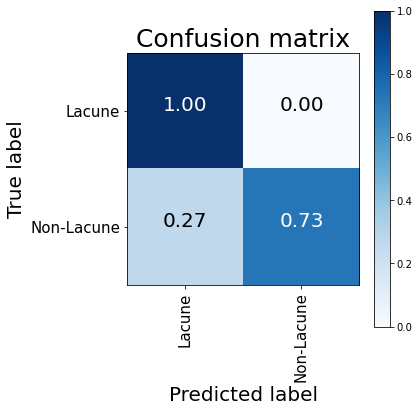

In [24]:
# species =['Normal','Anterior','Posterior']
species = ['Lacune', 'Non-Lacune']
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, species)